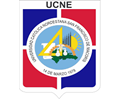

# UNIVERSIDAD CATÓLICA NORDESTANA (UCNE)
San Francisco de Macorís, Rep. Dom.
MAESTRÍA EN INVESTIGACIÓN CIENTÍFICA

# Extracción de Métricas de Calidad de Software desde SonarCloud

Este notebook está diseñado para cargar datos de estudiantes con proyectos de SonarCloud y extraer métricas de calidad de software utilizando la API de SonarCloud.

## Objetivos:
1. **Cargar datos** de estudiantes desde el archivo CSV con columnas Sonar_Ap1 y Sonar_Ap2
2. **Extraer métricas** de calidad desde SonarCloud API para cada proyecto
3. **Procesar y combinar** los datos para crear un dataset completo
4. **Exportar resultados** para análisis posteriores

## Métricas a Extraer:
- `bugs`: Errores detectados
- `vulnerabilities`: Vulnerabilidades de seguridad
- `code_smells`: Problemas de mantenibilidad
- `technical_debt`: Deuda técnica
- `duplicated_lines_density`: Densidad de líneas duplicadas
- `ncloc`: Número de líneas de código
- `complexity`: Complejidad ciclomática
- `reliability_rating`: Rating de confiabilidad
- `sqale_rating`: Rating de mantenibilidad (SQALE)
- `open_issues`: Problemas abiertos
- `coverage`: Cobertura de código
- `security_rating`: Rating de seguridad
- `security_hotspots`: Puntos críticos de seguridad
- `comment_lines_density`: Densidad de líneas de comentarios
- `cognitive_complexity`: Complejidad cognitiva

In [1]:
# Instalación de dependencias (ejecutar solo si es necesario)
import subprocess
import sys

def install_package(package):
    """Instalar paquete si no está disponible"""
    try:
        __import__(package)
        print(f"✅ {package} ya está instalado")
    except ImportError:
        print(f"🔄 Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} instalado exitosamente")

# Lista de paquetes requeridos
required_packages = ['pandas', 'requests']

print("🔧 Verificando e instalando dependencias...")
for package in required_packages:
    install_package(package)

print("✅ Todas las dependencias están listas")

🔧 Verificando e instalando dependencias...
🔄 Instalando pandas...
✅ pandas instalado exitosamente
🔄 Instalando requests...
✅ requests instalado exitosamente
✅ Todas las dependencias están listas


In [ ]:
# Importar librerías necesarias
import pandas as pd
import requests
import json
import base64
import time
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")
print("📝 Pandas version:", pd.__version__)
print("🌐 Requests disponible para API calls")

✅ Librerías importadas correctamente
📝 Pandas version: 2.3.1
🌐 Requests disponible para API calls


In [ ]:
# Funciones utilitarias para optimizar el código
from functools import wraps
import logging

# Configurar logging básico
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def timer_decorator(func):
    """Decorador para medir tiempo de ejecución de funciones"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        import time
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"⏱️  {func.__name__} ejecutado en {end_time - start_time:.2f} segundos")
        return result
    return wrapper

def validate_dataframe(df, required_columns=None):
    """Validar la estructura básica de un DataFrame"""
    if df is None or len(df) == 0:
        raise ValueError("DataFrame está vacío o es None")
    
    if required_columns:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columnas faltantes: {missing_cols}")
    
    return True

def safe_divide(numerator, denominator):
    """División segura que evita división por cero"""
    return numerator / denominator if denominator != 0 else 0

def format_percentage(value, total):
    """Formatear porcentaje de manera consistente"""
    return f"{safe_divide(value, total) * 100:.1f}%"

def print_section_header(title, char="=", width=50):
    """Imprimir headers de sección consistentes"""
    print(f"\n{title}")
    print(char * width)

print("🛠️  Funciones utilitarias cargadas")
print("📊 Timer, validaciones y formateo disponibles")

🛠️  Funciones utilitarias cargadas
📊 Timer, validaciones y formateo disponibles


## 1. Configuración del Entorno

En esta sección importamos todas las librerías necesarias para el procesamiento de datos y la comunicación con la API de SonarCloud.

In [ ]:
# Configuración de SonarCloud API
from functools import lru_cache

# Configuración del token (expuesto temporalmente para pruebas)
SONAR_TOKEN = "8ec2e705f1a4ee79a8a86ff5a2170f27f922270e"
SONAR_BASE_URL = "https://sonarcloud.io/api"

# Cache para headers de autenticación
@lru_cache(maxsize=1)
def get_auth_headers():
    """Crear headers de autenticación para SonarCloud API (con caché)"""
    # Codificar token en base64 para autenticación básica
    auth_string = f"{SONAR_TOKEN}:"
    auth_bytes = auth_string.encode('ascii')
    auth_b64 = base64.b64encode(auth_bytes).decode('ascii')

    return {
        'Authorization': f'Basic {auth_b64}',
        'Content-Type': 'application/json'
    }

# Definir métricas a extraer (agrupadas por categoría para mejor organización)
METRICS_CONFIG = {
    'errors_vulnerabilities': ["bugs", "vulnerabilities", "security_hotspots"],
    'maintainability': ["code_smells", "technical_debt", "sqale_rating"],
    'complexity': ["complexity", "cognitive_complexity"],
    'coverage_docs': ["coverage", "comment_lines_density"],
    'duplication': ["duplicated_lines_density"],
    'size': ["ncloc"],
    'ratings': ["reliability_rating", "security_rating"],
    'issues': ["open_issues"]
}

# Lista plana de métricas para compatibilidad
METRICS = [metric for category in METRICS_CONFIG.values() for metric in category]

print("🔐 Configuración de autenticación preparada")
print(f"📊 {len(METRICS)} métricas configuradas para extracción")
print("✅ Headers de API configurados con caché")
print("⚠️  Token expuesto temporalmente para pruebas")

🔐 Configuración de autenticación preparada
📊 15 métricas configuradas para extracción
✅ Headers de API configurados con caché
⚠️  Token expuesto temporalmente para pruebas


## 2. Configuración de la API de SonarCloud

Configuramos los parámetros necesarios para conectarnos a SonarCloud:

- **Token de autenticación**: Credenciales para acceder a la API
- **Headers de autenticación**: Configuración básica con base64 encoding
- **Métricas objetivo**: Lista de 15 métricas de calidad de software a extraer

### Métricas de Calidad Configuradas:
Las métricas se dividen en varias categorías:
- **Errores y vulnerabilidades**: `bugs`, `vulnerabilities`, `security_hotspots`
- **Mantenibilidad**: `code_smells`, `technical_debt`, `sqale_rating`
- **Complejidad**: `complexity`, `cognitive_complexity`
- **Cobertura y documentación**: `coverage`, `comment_lines_density`
- **Duplicación**: `duplicated_lines_density`
- **Tamaño**: `ncloc` (lines of code)
- **Ratings**: `reliability_rating`, `security_rating`

In [ ]:
# Cargar datos de estudiantes
CSV_PATH = "https://raw.githubusercontent.com/TesisEnel/Recopilacion_Datos_CalidadCodigo/refs/heads/main/data/Estudiantes_2023-2024.csv"

try:
    # Cargar el CSV con información de estudiantes
    df_estudiantes = pd.read_csv(CSV_PATH)

    print("📁 Datos cargados exitosamente")
    print(f"👥 Número de estudiantes: {len(df_estudiantes)}")
    print(f"📊 Columnas disponibles: {list(df_estudiantes.columns)}")

    # Mostrar información básica del dataset
    print("\n🔍 Primeras 3 filas del dataset:")
    display(df_estudiantes.head(3))

    # Verificar columnas de SonarCloud
    sonar_columns = [col for col in df_estudiantes.columns if 'Sonar' in col]
    print(f"\n🎯 Columnas de SonarCloud encontradas: {sonar_columns}")

    # Contar proyectos no vacíos
    sonar_ap1_count = df_estudiantes['Sonar_Ap1'].notna().sum()
    sonar_ap2_count = df_estudiantes['Sonar_Ap2'].notna().sum()

    print(f"📈 Proyectos Sonar_Ap1 disponibles: {sonar_ap1_count}")
    print(f"📈 Proyectos Sonar_Ap2 disponibles: {sonar_ap2_count}")
    print(f"📈 Total de proyectos a procesar: {sonar_ap1_count + sonar_ap2_count}")

except FileNotFoundError:
    print("❌ Error: No se encontró el archivo CSV")
    print(f"📍 Buscando en: {CSV_PATH}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")

📁 Datos cargados exitosamente
👥 Número de estudiantes: 60
📊 Columnas disponibles: ['Id', 'Semestre', 'Estudiante', 'Sexo', 'Email', 'Original_Repo_Ap1', 'Original_Repo_Ap2', 'Sonar_Ap1', 'Sonar_Ap2', 'Sonar_Repo_Ap1', 'Sonar_Repo_Ap2']

🔍 Primeras 3 filas del dataset:


,Id,Semestre,Estudiante,Sexo,Email,Original_Repo_Ap1,Original_Repo_Ap2,Sonar_Ap1,Sonar_Ap2,Sonar_Repo_Ap1,Sonar_Repo_Ap2
0,1,2024-01,Aaron Eliezer Hernández García,1,atminifg655@gmail.com,https://github.com/aaron-developer25/SwiftPay.git,https://github.com/aaron-developer25/DealerPOS...,TesisEnel_SwiftPay-Aaron-Ap1,TesisEnel_DealerPOS-Aaron-ap2,https://github.com/TesisEnel/SwiftPay-Aaron-Ap1,https://github.com/TesisEnel/DealerPOS-Aaron-ap2
1,2,2023-03,Abraham El Hage Jreij,1,abrahamelhage2003@gmail.com,https://github.com/JPichardo2003/AguaMariaSolu...,https://github.com/A-EHJ/Final_Project_Ap2.git,TesisEnel_AguaMariaSolution-JulioPichardo-ap1,TesisEnel_Final_Project-Abraham-ap2,https://github.com/TesisEnel/AguaMariaSolution...,https://github.com/TesisEnel/Final_Project-Abr...
2,3,2024-02,Adiel Luis García Rosa,1,adiel.garcia0422@gmail.com,https://github.com/SamyJp23/PeakPerformance.git,https://github.com/Adiel040/GymProApp.git,TesisEnel_PeakPerformance-samuelAntonio-ap1,TesisEnel_GymProApp-AdielGarcia-Ap2,https://github.com/TesisEnel/PeakPerformance-s...,https://github.com/TesisEnel/GymProApp-AdielGa...



🎯 Columnas de SonarCloud encontradas: ['Sonar_Ap1', 'Sonar_Ap2', 'Sonar_Repo_Ap1', 'Sonar_Repo_Ap2']
📈 Proyectos Sonar_Ap1 disponibles: 60
📈 Proyectos Sonar_Ap2 disponibles: 60
📈 Total de proyectos a procesar: 120


## 3. Carga de Datos de Estudiantes

Cargamos el archivo CSV que contiene la información de los estudiantes, incluyendo las columnas `Sonar_Ap1` y `Sonar_Ap2` que contienen las claves de los proyectos en SonarCloud.

### Estructura esperada del CSV:
- **ID**: Identificador único del estudiante
- **Nombre**: Nombre del estudiante  
- **Sonar_Ap1**: Clave del proyecto de la Aplicación 1 en SonarCloud
- **Sonar_Ap2**: Clave del proyecto de la Aplicación 2 en SonarCloud
- **Otras columnas**: Información adicional del estudiante

## 4. Extracción de Claves de Proyecto

Procesamos el DataFrame de estudiantes para extraer todas las claves de proyecto de SonarCloud disponibles. Cada estudiante puede tener hasta 2 proyectos (AP1 y AP2).

### Función implementada:

#### `extract_project_keys(df)`
- **Propósito**: Extraer y estructurar las claves de proyecto desde el DataFrame de estudiantes
- **Proceso**:
  1. **Iteración por estudiante**: Revisamos cada fila del DataFrame
  2. **Validación de datos**: Verificamos que las celdas no estén vacías
  3. **Estructuración**: Creamos una lista con la información del proyecto y estudiante
  4. **Categorización**: Separamos por assignment (AP1 vs AP2)

### Datos extraídos por proyecto:
- `student_id`: ID del estudiante
- `nombre`: Nombre del estudiante
- `project_key`: Clave del proyecto en SonarCloud
- `assignment`: Tipo de aplicación (AP1 o AP2)
- `row_index`: Índice de la fila para futuras referencias

### Estadísticas generadas:
- Total de claves de proyecto extraídas
- Conteo por assignment (AP1 vs AP2)
- Ejemplos de los primeros 5 proyectos
- DataFrame estructurado para procesamiento posterior

El resultado es una lista estructurada que facilita el procesamiento posterior con la API.

In [ ]:
# Extraer project keys de SonarCloud
def extract_project_keys(df):
    """
    Extraer todas las claves de proyecto de SonarCloud del DataFrame
    """
    project_keys = []

    for index, row in df.iterrows():
        student_id = row.get('ID', f'Student_{index}')
        nombre = row.get('Estudiante', 'Unknown')

        # Procesar Sonar_Ap1
        if pd.notna(row['Sonar_Ap1']) and row['Sonar_Ap1'].strip():
            project_keys.append({
                'student_id': student_id,
                'nombre': nombre,
                'project_key': row['Sonar_Ap1'].strip(),
                'assignment': 'AP1',
                'row_index': index
            })

        # Procesar Sonar_Ap2
        if pd.notna(row['Sonar_Ap2']) and row['Sonar_Ap2'].strip():
            project_keys.append({
                'student_id': student_id,
                'nombre': nombre,
                'project_key': row['Sonar_Ap2'].strip(),
                'assignment': 'AP2',
                'row_index': index
            })

    return project_keys

# Extraer project keys
project_list = extract_project_keys(df_estudiantes)

print(f"🔑 Total de project keys extraídos: {len(project_list)}")

# Mostrar estadísticas por assignment
ap1_count = len([p for p in project_list if p['assignment'] == 'AP1'])
ap2_count = len([p for p in project_list if p['assignment'] == 'AP2'])

print(f"📊 Proyectos AP1: {ap1_count}")
print(f"📊 Proyectos AP2: {ap2_count}")

# Mostrar algunos ejemplos
print("\n🔍 Primeros 5 project keys:")
for i, project in enumerate(project_list[:5]):
    print(f"  {i+1}. {project['nombre']} - {project['assignment']}: {project['project_key']}")

# Crear DataFrame con los project keys
df_projects = pd.DataFrame(project_list)
print(f"\n✅ DataFrame de proyectos creado con {len(df_projects)} filas")

🔑 Total de project keys extraídos: 120
📊 Proyectos AP1: 60
📊 Proyectos AP2: 60

🔍 Primeros 5 project keys:
  1. Aaron Eliezer Hernández García - AP1: TesisEnel_SwiftPay-Aaron-Ap1
  2. Aaron Eliezer Hernández García - AP2: TesisEnel_DealerPOS-Aaron-ap2
  3. Abraham El Hage Jreij - AP1: TesisEnel_AguaMariaSolution-JulioPichardo-ap1
  4. Abraham El Hage Jreij - AP2: TesisEnel_Final_Project-Abraham-ap2
  5. Adiel Luis García Rosa - AP1: TesisEnel_PeakPerformance-samuelAntonio-ap1

✅ DataFrame de proyectos creado con 120 filas


## 4. Implementación de Funciones de Interacción con la API

Implementamos las funciones principales para interactuar con la API de SonarCloud de manera eficiente y robusta, incluyendo optimizaciones y manejo completo de errores.

### Funciones implementadas:

#### `fetch_project_metrics(project_key, metrics_list)`
- **Propósito**: Obtener métricas de un proyecto específico desde SonarCloud
- **Endpoint**: `/api/measures/component`
- **Características**:
  - ⏱️ **Timing con decorador**: Mide tiempo de ejecución
  - 🔄 **Sistema de reintentos**: 3 intentos con delay configurable
  - 🛡️ **Manejo robusto de errores**: Captura errores HTTP, conexión y timeout
  - 📊 **Conversión automática de tipos**: Float/int según el tipo de métrica
  - 📝 **Logging estructurado**: Registra warnings y errores

#### `batch_fetch_metrics(project_list, batch_size, delay)`
- **Propósito**: Procesar múltiples proyectos con control de rate limiting
- **Características**:
  - ⚡ **Procesamiento por lotes**: Evita sobrecargar la API
  - 📊 **Progreso en tiempo real**: Indicadores de avance por batch
  - 🎯 **Estadísticas detalladas**: Tasa de éxito/fallo al final
  - ⏳ **Rate limiting inteligente**: Delays configurables entre batches
  - 🛡️ **Tolerancia a fallos**: Continúa aunque fallen proyectos individuales
  - ✅ **Validación de entrada**: Verifica estructura de datos

#### Funciones auxiliares:
- `convert_metric_value()`: Conversión inteligente de tipos de datos
- `create_error_response()`: Respuestas de error estandarizadas

In [ ]:
# Funciones para interactuar con SonarCloud API (OPTIMIZADAS)

@timer_decorator
def fetch_project_metrics(project_key: str, metrics_list: List[str], retries: int = 3, delay: float = 5.0) -> Dict:
    """
    Obtener métricas de un proyecto específico desde SonarCloud con reintentos
    Versión optimizada con mejor manejo de errores y logging
    """
    url = f"{SONAR_BASE_URL}/measures/component"
    params = {
        'component': project_key,
        'metricKeys': ','.join(metrics_list)
    }

    for attempt in range(retries):
        try:
            response = requests.get(url, params=params, headers=get_auth_headers(), timeout=30)

            if response.status_code == 200:
                data = response.json()
                metrics_dict = {'project_key': project_key, 'status': 'success'}

                # Extraer métricas de manera más eficiente
                if 'component' in data and 'measures' in data['component']:
                    measures_map = {measure['metric']: measure.get('value') for measure in data['component']['measures']}
                    
                    for metric in metrics_list:
                        value = measures_map.get(metric)
                        metrics_dict[metric] = convert_metric_value(metric, value)
                else:
                    # Inicializar todas las métricas como None si no hay datos
                    metrics_dict.update({metric: None for metric in metrics_list})

                return metrics_dict

            elif response.status_code == 401:
                logger.warning(f"Authentication error for project {project_key}")
                if attempt == retries - 1:
                    return create_error_response(project_key, 'authentication_error', response.status_code)
            else:
                logger.warning(f"HTTP error {response.status_code} for project {project_key}")
                if attempt == retries - 1:
                    return create_error_response(project_key, f'http_error_{response.status_code}', response.status_code)

            time.sleep(delay)

        except requests.exceptions.RequestException as e:
            logger.error(f"Connection error for project {project_key}: {e}")
            if attempt == retries - 1:
                return create_error_response(project_key, 'connection_error', str(e))
            time.sleep(delay)
        except Exception as e:
            logger.error(f"Unexpected error for project {project_key}: {e}")
            if attempt == retries - 1:
                return create_error_response(project_key, 'unexpected_error', str(e))
            time.sleep(delay)

    return create_error_response(project_key, 'failed_after_retries', 'Exceeded maximum retries')


def convert_metric_value(metric_key: str, value):
    """Convertir valores de métricas al tipo apropiado"""
    if value is None:
        return None
    
    try:
        # Métricas que deben ser float
        float_metrics = ['coverage', 'duplicated_lines_density', 'comment_lines_density']
        if '.' in str(value) or metric_key in float_metrics:
            return float(value)
        else:
            return int(value)
    except ValueError:
        return value  # Mantener como string si no se puede convertir


def create_error_response(project_key: str, status: str, error_info=None):
    """Crear respuesta de error estandarizada"""
    response = {'project_key': project_key, 'status': status}
    if error_info:
        response['error'] = error_info
    return response


@timer_decorator
def batch_fetch_metrics(project_list: List[Dict], batch_size: int = 5, delay: float = 1.0) -> List[Dict]:
    """
    Obtener métricas para múltiples proyectos con control de rate limiting
    Versión optimizada con mejor progreso y estadísticas
    """
    validate_dataframe(pd.DataFrame(project_list), ['project_key'])
    
    results = []
    total_projects = len(project_list)
    total_batches = (total_projects + batch_size - 1) // batch_size

    print_section_header(f"🚀 Extracción de métricas para {total_projects} proyectos")
    print(f"⚙️  Configuración: {batch_size} proyectos por batch, {delay}s de delay")

    for i in range(0, total_projects, batch_size):
        batch = project_list[i:i + batch_size]
        batch_num = (i // batch_size) + 1

        print(f"\n📦 Batch {batch_num}/{total_batches} ({len(batch)} proyectos)")

        batch_results = []
        for project in batch:
            project_key = project['project_key']
            print(f"  🔄 {project_key}")

            metrics = fetch_project_metrics(project_key, METRICS)
            result = {**project, **metrics}
            batch_results.append(result)

            # Indicador de estado
            status_icon = "✅" if metrics['status'] == 'success' else "❌"
            print(f"    {status_icon} {metrics.get('status', 'unknown')}")

        results.extend(batch_results)

        # Progress update
        progress = len(results) / total_projects * 100
        print(f"  📊 Progreso: {progress:.1f}% ({len(results)}/{total_projects})")

        # Delay entre batches
        if i + batch_size < total_projects:
            print(f"  ⏳ Esperando {delay}s...")
            time.sleep(delay)

    # Estadísticas finales
    successful = [r for r in results if r.get('status') == 'success']
    print_section_header("📈 Estadísticas de Extracción")
    print(f"✅ Exitosos: {len(successful)} ({format_percentage(len(successful), total_projects)})")
    print(f"❌ Fallidos: {total_projects - len(successful)} ({format_percentage(total_projects - len(successful), total_projects)})")

    return results

print("🛠️  Funciones de API optimizadas y configuradas")
print("📡 Listo para extraer métricas con mejor rendimiento")

🛠️  Funciones de API optimizadas y configuradas
📡 Listo para extraer métricas con mejor rendimiento


## 5. Ejecución de la Extracción de Métricas

Ejecutamos el proceso de extracción de métricas utilizando las funciones optimizadas. Este es el paso operativo donde se realiza la comunicación real con la API de SonarCloud.

### Configuración de parámetros:
- **BATCH_SIZE**: 3 proyectos por lote (optimizado para evitar rate limiting)
- **DELAY_BETWEEN_BATCHES**: 2.0 segundos de espera entre lotes

### Proceso de ejecución:
1. **Llamada a batch_fetch_metrics()**: Procesa todos los proyectos en lotes
2. **Análisis de resultados**: Separa extracciones exitosas de fallidas
3. **Reporte de estadísticas**: Cuenta y porcentajes de éxito/fallo
4. **Muestra de datos**: Ejemplo de métricas extraídas del primer proyecto exitoso

### Monitoreo incluido:
- ✅ **Extracciones exitosas**: Proyectos procesados correctamente
- ❌ **Extracciones fallidas**: Proyectos con errores (proyecto no encontrado, permisos, etc.)
- 📊 **Progreso en tiempo real**: Indicadores de estado por cada proyecto y batch
- 🔍 **Vista previa de datos**: Muestra métricas clave del primer proyecto exitoso

### Salidas generadas:
- `metrics_results`: Lista completa con todos los resultados
- `successful_extractions`: Solo proyectos con métricas extraídas exitosamente  
- `failed_extractions`: Proyectos que fallaron con información del error

> **Nota**: El proceso puede tomar varios minutos dependiendo del número de proyectos. Los delays son necesarios para respetar los límites de la API de SonarCloud.

In [ ]:
# Ejecutar extracción de métricas
print("🚀 Iniciando proceso de extracción de métricas...")
print(f"📊 Total de proyectos a procesar: {len(project_list)}")

# Configurar parámetros de extracción
BATCH_SIZE = 3  # Reducir para evitar rate limiting
DELAY_BETWEEN_BATCHES = 2.0  # Segundos de espera entre batches

# Ejecutar extracción
metrics_results = batch_fetch_metrics(
    project_list=project_list,
    batch_size=BATCH_SIZE,
    delay=DELAY_BETWEEN_BATCHES
)

print("\n📈 Resultados de la extracción:")
print(f"✅ Total de proyectos procesados: {len(metrics_results)}")

# Analizar resultados
successful_extractions = [r for r in metrics_results if r.get('status') == 'success']
failed_extractions = [r for r in metrics_results if r.get('status') != 'success']

print(f"✅ Extracciones exitosas: {len(successful_extractions)}")
print(f"❌ Extracciones fallidas: {len(failed_extractions)}")

if failed_extractions:
    print("\n⚠️  Proyectos con errores:")
    for failed in failed_extractions[:5]:  # Mostrar solo los primeros 5
        print(f"  - {failed['project_key']}: {failed.get('status', 'unknown error')}")

# Mostrar ejemplo de métricas extraídas
if successful_extractions:
    print("\n🔍 Ejemplo de métricas extraídas (primer proyecto exitoso):")
    example = successful_extractions[0]
    print(f"Proyecto: {example['project_key']}")
    print(f"Estudiante: {example['nombre']}")
    print(f"Assignment: {example['assignment']}")

    # Mostrar algunas métricas clave
    key_metrics = ['bugs', 'vulnerabilities', 'code_smells', 'ncloc', 'coverage']
    for metric in key_metrics:
        value = example.get(metric, 'N/A')
        print(f"  {metric}: {value}")

print("\n✅ Extracción de métricas completada")

🚀 Iniciando proceso de extracción de métricas...
📊 Total de proyectos a procesar: 120

🚀 Extracción de métricas para 120 proyectos
⚙️  Configuración: 3 proyectos por batch, 2.0s de delay

📦 Batch 1/40 (3 proyectos)
  🔄 TesisEnel_SwiftPay-Aaron-Ap1
⏱️  fetch_project_metrics ejecutado en 0.76 segundos
    ✅ success
  🔄 TesisEnel_DealerPOS-Aaron-ap2
⏱️  fetch_project_metrics ejecutado en 0.41 segundos
    ✅ success
  🔄 TesisEnel_AguaMariaSolution-JulioPichardo-ap1
⏱️  fetch_project_metrics ejecutado en 0.41 segundos
    ✅ success
  📊 Progreso: 2.5% (3/120)
  ⏳ Esperando 2.0s...

📦 Batch 2/40 (3 proyectos)
  🔄 TesisEnel_Final_Project-Abraham-ap2
⏱️  fetch_project_metrics ejecutado en 0.45 segundos
    ✅ success
  🔄 TesisEnel_PeakPerformance-samuelAntonio-ap1
⏱️  fetch_project_metrics ejecutado en 0.42 segundos
    ✅ success
  🔄 TesisEnel_GymProApp-AdielGarcia-Ap2
⏱️  fetch_project_metrics ejecutado en 1.02 segundos
    ✅ success
  📊 Progreso: 5.0% (6/120)
  ⏳ Esperando 2.0s...

📦 Batch 3/4

## 6. Procesamiento y Análisis de Datos Extraídos

Convertimos los resultados de la extracción en un DataFrame estructurado y realizamos un análisis inicial de la calidad de los datos.

### Procesamiento realizado:
1. **Creación de DataFrame**: Convierte `successful_extractions` en DataFrame pandas
2. **Separación de columnas**: Distingue información del proyecto vs métricas
3. **Análisis estadístico**: Genera estadísticas descriptivas de métricas numéricas
4. **Validación de datos**: Identifica valores nulos y patrones

### Análisis incluido:
- **📊 Estadísticas descriptivas**: Media, mediana, min, max para métricas numéricas
- **❓ Análisis de valores nulos**: Identificación de métricas faltantes por proyecto
- **📈 Distribución por assignment**: Conteo de proyectos AP1 vs AP2 exitosos
- **🔍 Vista previa**: Primeras filas del dataset para validación visual

### Separación de columnas:
- **Información del proyecto**: student_id, nombre, project_key, assignment, row_index, status
- **Métricas de calidad**: bugs, vulnerabilities, code_smells, ncloc, coverage, etc.

### Variables generadas:
- `df_metrics`: DataFrame con métricas extraídas exitosamente
- `info_columns`: Lista de columnas de información del proyecto
- `metric_columns`: Lista de columnas con métricas de calidad
- `numeric_metrics`: Subset con solo métricas numéricas
- `stats`: Estadísticas descriptivas completas

Este análisis nos permite identificar patrones y posibles problemas en los datos antes de continuar con la combinación.

In [ ]:
# Procesar y estructurar los datos extraídos
print("🔄 Procesando datos extraídos...")

# Crear DataFrame con las métricas extraídas
df_metrics = pd.DataFrame(successful_extractions)

if len(df_metrics) > 0:
    print(f"📊 DataFrame de métricas creado con {len(df_metrics)} filas")

    # Mostrar información del DataFrame
    print(f"📋 Columnas disponibles: {len(df_metrics.columns)}")

    # Separar columnas de información del proyecto vs métricas
    info_columns = ['student_id', 'nombre', 'project_key', 'assignment', 'row_index', 'status']
    metric_columns = [col for col in df_metrics.columns if col not in info_columns]

    print(f"📈 Métricas extraídas: {len(metric_columns)}")
    print(f"ℹ️  Columnas de información: {len(info_columns)}")

    # Mostrar estadísticas básicas de las métricas numéricas
    numeric_metrics = df_metrics[metric_columns].select_dtypes(include=['number'])

    if len(numeric_metrics.columns) > 0:
        print(f"\n📊 Estadísticas descriptivas de métricas numéricas:")
        print(f"Métricas numéricas encontradas: {list(numeric_metrics.columns)}")

        # Mostrar estadísticas básicas
        stats = numeric_metrics.describe()
        display(stats.round(2))

        # Verificar valores nulos
        null_counts = df_metrics[metric_columns].isnull().sum()
        print(f"\n❓ Valores nulos por métrica:")
        for metric, null_count in null_counts.items():
            if null_count > 0:
                print(f"  {metric}: {null_count}/{len(df_metrics)} ({null_count/len(df_metrics)*100:.1f}%)")

    # Mostrar distribución por assignment
    assignment_dist = df_metrics['assignment'].value_counts()
    print(f"\n📊 Distribución por assignment:")
    for assignment, count in assignment_dist.items():
        print(f"  {assignment}: {count} proyectos")

    # Mostrar primeras filas del DataFrame
    print(f"\n🔍 Primeras 3 filas del dataset de métricas:")
    display(df_metrics[info_columns + metric_columns[:5]].head(3))

else:
    print("❌ No se pudieron procesar las métricas extraídas")
    df_metrics = pd.DataFrame()

print("✅ Procesamiento de datos completado")

🔄 Procesando datos extraídos...
📊 DataFrame de métricas creado con 120 filas
📋 Columnas disponibles: 21
📈 Métricas extraídas: 15
ℹ️  Columnas de información: 6

📊 Estadísticas descriptivas de métricas numéricas:
Métricas numéricas encontradas: ['bugs', 'vulnerabilities', 'security_hotspots', 'code_smells', 'sqale_rating', 'complexity', 'cognitive_complexity', 'coverage', 'comment_lines_density', 'duplicated_lines_density', 'ncloc', 'reliability_rating', 'security_rating', 'open_issues']


,bugs,vulnerabilities,security_hotspots,code_smells,sqale_rating,complexity,cognitive_complexity,coverage,comment_lines_density,duplicated_lines_density,ncloc,reliability_rating,security_rating,open_issues
count,120.00,120.00,120.00,120.00,120.0,120.00,120.00,14.0,120.00,120.00,120.00,120.00,120.00,120.00
mean,2.33,0.32,1.57,67.04,1.0,446.70,322.16,0.0,2.86,4.26,5390.81,1.85,2.08,69.69
std,5.32,0.53,1.36,62.90,0.0,349.23,404.55,0.0,2.50,6.64,4768.18,1.17,1.76,64.65
min,0.00,0.00,0.00,8.00,1.0,49.00,15.00,0.0,0.10,0.00,1056.00,1.00,1.00,8.00
25%,0.00,0.00,1.00,30.25,1.0,201.00,51.75,0.0,1.20,0.40,2234.75,1.00,1.00,31.25
50%,0.00,0.00,1.00,43.00,1.0,323.00,154.00,0.0,2.35,1.95,3107.00,1.00,1.00,46.00
75%,1.00,1.00,2.00,73.75,1.0,619.00,415.00,0.0,3.82,5.90,6773.00,3.00,5.00,76.00
max,31.00,2.00,7.00,294.00,1.0,1735.00,1776.00,0.0,18.90,39.10,25937.00,5.00,5.00,299.00



❓ Valores nulos por métrica:
  technical_debt: 120/120 (100.0%)
  coverage: 106/120 (88.3%)

📊 Distribución por assignment:
  AP1: 60 proyectos
  AP2: 60 proyectos

🔍 Primeras 3 filas del dataset de métricas:


,student_id,nombre,project_key,assignment,row_index,status,bugs,vulnerabilities,security_hotspots,code_smells,technical_debt
0,Student_0,Aaron Eliezer Hernández García,TesisEnel_SwiftPay-Aaron-Ap1,AP1,0,success,8,2,0,239,None
1,Student_0,Aaron Eliezer Hernández García,TesisEnel_DealerPOS-Aaron-ap2,AP2,0,success,2,1,2,238,None
2,Student_1,Abraham El Hage Jreij,TesisEnel_AguaMariaSolution-JulioPichardo-ap1,AP1,1,success,0,0,1,47,None


✅ Procesamiento de datos completado


## 7. Combinación de Datos de Estudiantes con Métricas

Integramos las métricas extraídas con la información original de los estudiantes para crear un dataset completo y listo para análisis.

### Proceso de combinación optimizado:
1. **Preservación de estructura**: Mantenemos todas las columnas del CSV original de estudiantes
2. **Separación por assignment**: Procesamos AP1 y AP2 independientemente para mayor eficiencia
3. **Sufijos de identificación**: Agregamos `_AP1` y `_AP2` a cada métrica para distinguir assignments
4. **Joins optimizados**: Utilizamos pandas joins en lugar de iteraciones para mejor rendimiento
5. **Manejo de datos faltantes**: Asignamos `None` para proyectos sin métricas disponibles

### Función optimizada implementada:
- **`merge_student_data_with_metrics()`**: Función principal de combinación
- **Separación eficiente**: Divide métricas por assignment antes del procesamiento
- **Pivot operations**: Usa `set_index()` y `add_suffix()` para restructuración eficiente
- **Left joins**: Preserva todos los estudiantes, incluso sin métricas

### Estructura del dataset resultante:
- **Columnas originales**: ID, Nombre, Sonar_Ap1, Sonar_Ap2, etc.
- **30 nuevas columnas de métricas**: 15 métricas × 2 assignments (AP1/AP2)
- **Nomenclatura consistente**: `{metrica}_{assignment}` (ej: `bugs_AP1`, `ncloc_AP2`)

### Validación incluida:
- **📊 Conteo de cobertura**: Estudiantes con métricas AP1/AP2
- **📋 Verificación de columnas**: Confirmación de estructura correcta
- **🔍 Vista previa**: Muestra sample del dataset combinado

### Variables generadas:
- `df_combined`: Dataset final con estudiantes + métricas
- `metric_ap1_cols`/`metric_ap2_cols`: Listas de columnas de métricas por assignment
- Estadísticas de cobertura por assignment

Esta combinación optimizada nos permite mantener la integridad de los datos originales mientras agregamos las métricas de calidad de manera estructurada y eficiente.

In [ ]:
# Combinar datos de estudiantes con métricas extraídas (OPTIMIZADO)
def merge_student_data_with_metrics(df_estudiantes, df_metrics):
    """
    Combinar datos originales de estudiantes con las métricas extraídas
    Versión optimizada usando pandas operations
    """
    print("🔗 Iniciando proceso de combinación de datos optimizado...")

    # Crear copia del DataFrame de estudiantes
    df_combined = df_estudiantes.copy()
    
    # Separar métricas por assignment para procesamiento más eficiente
    df_ap1 = df_metrics[df_metrics['assignment'] == 'AP1'].copy()
    df_ap2 = df_metrics[df_metrics['assignment'] == 'AP2'].copy()
    
    # Función helper para agregar métricas
    def add_metrics_suffix(df_source, suffix):
        """Agregar sufijo a las columnas de métricas"""
        metrics_dict = {}
        for metric in METRICS:
            metrics_dict[f'{metric}_{suffix}'] = df_source.get(metric, None)
        return metrics_dict
    
    # Procesar métricas AP1
    if len(df_ap1) > 0:
        df_ap1_pivot = df_ap1.set_index('row_index')[METRICS].add_suffix('_AP1')
        df_combined = df_combined.join(df_ap1_pivot, how='left')
    else:
        # Agregar columnas vacías si no hay datos AP1
        for metric in METRICS:
            df_combined[f'{metric}_AP1'] = None
    
    # Procesar métricas AP2
    if len(df_ap2) > 0:
        df_ap2_pivot = df_ap2.set_index('row_index')[METRICS].add_suffix('_AP2')
        df_combined = df_combined.join(df_ap2_pivot, how='left')
    else:
        # Agregar columnas vacías si no hay datos AP2
        for metric in METRICS:
            df_combined[f'{metric}_AP2'] = None

    return df_combined

# Ejecutar combinación de datos optimizada
if len(df_metrics) > 0:
    df_combined = merge_student_data_with_metrics(df_estudiantes, df_metrics)

    print(f"✅ Datos combinados exitosamente")
    print(f"👥 Estudiantes en dataset combinado: {len(df_combined)}")
    print(f"📊 Total de columnas: {len(df_combined.columns)}")

    # Contar columnas de métricas añadidas
    metric_ap1_cols = [col for col in df_combined.columns if col.endswith('_AP1')]
    metric_ap2_cols = [col for col in df_combined.columns if col.endswith('_AP2')]

    print(f"📈 Columnas de métricas AP1: {len(metric_ap1_cols)}")
    print(f"📈 Columnas de métricas AP2: {len(metric_ap2_cols)}")

    # Verificar cobertura de datos (optimizado)
    ap1_projects_with_metrics = df_combined[metric_ap1_cols].notna().any(axis=1).sum()
    ap2_projects_with_metrics = df_combined[metric_ap2_cols].notna().any(axis=1).sum()

    print(f"\n📊 Cobertura de métricas:")
    print(f"  Estudiantes con métricas AP1: {ap1_projects_with_metrics}")
    print(f"  Estudiantes con métricas AP2: {ap2_projects_with_metrics}")

    # Mostrar algunas columnas del dataset combinado
    sample_columns = ['ID', 'Estudiante', 'Sonar_Ap1', 'Sonar_Ap2', 'bugs_AP1', 'bugs_AP2', 'ncloc_AP1', 'ncloc_AP2']
    available_sample_cols = [col for col in sample_columns if col in df_combined.columns]

    if available_sample_cols:
        print(f"\n🔍 Vista previa del dataset combinado:")
        display(df_combined[available_sample_cols].head(3))

else:
    print("❌ No se pueden combinar datos sin métricas extraídas")
    df_combined = df_estudiantes.copy()

print("✅ Combinación de datos completada con optimizaciones")

🔗 Iniciando proceso de combinación de datos optimizado...
✅ Datos combinados exitosamente
👥 Estudiantes en dataset combinado: 60
📊 Total de columnas: 41
📈 Columnas de métricas AP1: 15
📈 Columnas de métricas AP2: 15

📊 Cobertura de métricas:
  Estudiantes con métricas AP1: 60
  Estudiantes con métricas AP2: 60

🔍 Vista previa del dataset combinado:


,Estudiante,Sonar_Ap1,Sonar_Ap2,bugs_AP1,bugs_AP2,ncloc_AP1,ncloc_AP2
0,Aaron Eliezer Hernández García,TesisEnel_SwiftPay-Aaron-Ap1,TesisEnel_DealerPOS-Aaron-ap2,8,2,6773,14674
1,Abraham El Hage Jreij,TesisEnel_AguaMariaSolution-JulioPichardo-ap1,TesisEnel_Final_Project-Abraham-ap2,0,0,5857,4075
2,Adiel Luis García Rosa,TesisEnel_PeakPerformance-samuelAntonio-ap1,TesisEnel_GymProApp-AdielGarcia-Ap2,1,0,2250,5736


✅ Combinación de datos completada con optimizaciones


## 8. Exportación de Resultados y Generación de Reportes

Finalizamos el proceso exportando los datos procesados y generando reportes comprensivos del proceso de extracción. Los archivos se generan con nombres fijos y se sobrescriben en cada ejecución.

### Archivos exportados (nombres fijos):

#### 1. Dataset Combinado Principal
- **Archivo**: `Estudiantes_2023-2024_con_metricas_sonarcloud.csv`
- **Contenido**: Datos originales de estudiantes + 30 columnas de métricas SonarCloud
- **Uso**: Análisis estadístico, visualizaciones, machine learning
- **Estructura**: Una fila por estudiante con todas las métricas AP1/AP2
- **Comportamiento**: Se sobrescribe en cada ejecución

#### 2. Métricas Raw (Formato Largo)
- **Archivo**: `metricas_sonarcloud_raw.csv`
- **Contenido**: Métricas extraídas en formato normalizado (una fila por proyecto)
- **Uso**: Análisis detallado por proyecto, debugging, auditoría
- **Estructura**: project_key, assignment, métricas individuales
- **Comportamiento**: Se sobrescribe en cada ejecución

#### 3. Configuración de Extracción
- **Archivo**: `extraction_config.json`
- **Contenido**: Parámetros utilizados, métricas configuradas, estadísticas del proceso
- **Uso**: Reproducibilidad, documentación, troubleshooting
- **Comportamiento**: Se sobrescribe en cada ejecución

### Reporte comprensivo generado:
- **📊 Estadísticas generales**: Total de estudiantes, proyectos identificados, extracciones exitosas
- **✅ Tasa de éxito**: Ratio de extracciones exitosas vs fallidas
- **📈 Cobertura de datos**: 
  - Estudiantes con métricas AP1, AP2, o ambas
  - Porcentaje de completitud por métrica específica
- **📋 Configuración documentada**: Parámetros de batch, delays, métricas extraídas

### Características de exportación:
- **? Nombres consistentes**: Archivos con nombres fijos para facilitar automatización
- **🔄 Sobrescritura automática**: Los archivos se reemplazan en cada ejecución
- **🔤 UTF-8 encoding**: Preservación correcta de caracteres especiales
- **📁 Organización**: Archivos generados en directorio de trabajo actual
- **🛡️ Error handling**: Manejo robusto de errores de escritura
- **🕐 Timestamp en reporte**: Fecha/hora de última extracción registrada en el archivo

### Estadísticas finales mostradas:
- Total de estudiantes procesados
- Proyectos SonarCloud identificados y procesados
- Métricas extraídas por assignment (AP1/AP2)
- Cobertura de datos por métrica clave

> **Importante**: Los archivos se sobrescriben en cada ejecución para mantener siempre la versión más actualizada. El timestamp se registra dentro del contenido para trazabilidad.

In [ ]:
# Exportar resultados y generar reportes (con nombres de archivo fijos)
from datetime import datetime

print("💾 Preparando exportación de resultados con nombres fijos...")

# 1. Exportar dataset combinado completo (nombre fijo)
output_file_combined = "Estudiantes_2023-2024_con_metricas_sonarcloud.csv"

try:
    df_combined.to_csv(output_file_combined, index=False, encoding='utf-8')
    print(f"✅ Dataset combinado exportado: {output_file_combined}")
    print(f"📊 Filas exportadas: {len(df_combined)}")
    print(f"📋 Columnas exportadas: {len(df_combined.columns)}")
    print(f"🔄 Archivo sobrescrito exitosamente")
except Exception as e:
    print(f"❌ Error al exportar dataset combinado: {e}")

# 2. Exportar solo las métricas extraídas (nombre fijo)
if len(df_metrics) > 0:
    output_file_metrics = "metricas_sonarcloud_raw.csv"
    try:
        df_metrics.to_csv(output_file_metrics, index=False, encoding='utf-8')
        print(f"✅ Métricas raw exportadas: {output_file_metrics}")
        print(f"📊 Proyectos exportados: {len(df_metrics)}")
        print(f"🔄 Archivo sobrescrito exitosamente")
    except Exception as e:
        print(f"❌ Error al exportar métricas raw: {e}")

# 3. Generar reporte de resumen
print(f"\n📋 REPORTE DE EXTRACCIÓN DE MÉTRICAS")
print(f"=" * 50)
print(f"🕐 Fecha y hora de extracción: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"👥 Total de estudiantes: {len(df_estudiantes)}")
print(f"🎯 Proyectos identificados: {len(project_list)}")
print(f"✅ Métricas extraídas exitosamente: {len(successful_extractions)}")
print(f"❌ Extracciones fallidas: {len(failed_extractions)}")
print(f"📊 Métricas por proyecto: {len(METRICS)}")

if len(df_combined) > 0:
    print(f"\n📈 ESTADÍSTICAS DEL DATASET FINAL:")

    # Contar estudiantes con datos completos
    students_with_ap1 = (df_combined[[col for col in df_combined.columns if col.endswith('_AP1')]].notna().any(axis=1)).sum()
    students_with_ap2 = (df_combined[[col for col in df_combined.columns if col.endswith('_AP2')]].notna().any(axis=1)).sum()
    students_with_both = (
        (df_combined[[col for col in df_combined.columns if col.endswith('_AP1')]].notna().any(axis=1)) &
        (df_combined[[col for col in df_combined.columns if col.endswith('_AP2')]].notna().any(axis=1))
    ).sum()

    print(f"  📊 Estudiantes con métricas AP1: {students_with_ap1}")
    print(f"  📊 Estudiantes con métricas AP2: {students_with_ap2}")
    print(f"  📊 Estudiantes con ambas métricas: {students_with_both}")

    # Mostrar cobertura por métrica
    print(f"\n📊 COBERTURA POR MÉTRICA (% de proyectos con datos):")
    for metric in METRICS[:5]:  # Mostrar las primeras 5 métricas
        ap1_coverage = df_combined[f'{metric}_AP1'].notna().sum() / len(df_combined) * 100
        ap2_coverage = df_combined[f'{metric}_AP2'].notna().sum() / len(df_combined) * 100
        print(f"  {metric}: AP1={ap1_coverage:.1f}%, AP2={ap2_coverage:.1f}%")

# 4. Guardar configuración utilizada (nombre fijo)
config_info = {
    'ultima_extraccion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_students': len(df_estudiantes),
    'projects_found': len(project_list),
    'metrics_extracted': len(successful_extractions),
    'extraction_failures': len(failed_extractions),
    'metrics_configured': METRICS,
    'batch_size': BATCH_SIZE,
    'delay_between_batches': DELAY_BETWEEN_BATCHES,
    'archivos_generados': {
        'dataset_combinado': output_file_combined,
        'metricas_raw': output_file_metrics if len(df_metrics) > 0 else None,
        'configuracion': 'extraction_config.json'
    }
}

config_file = "extraction_config.json"
try:
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(config_info, f, indent=2, ensure_ascii=False)
    print(f"\n✅ Configuración guardada: {config_file}")
    print(f"🔄 Archivo de configuración sobrescrito exitosamente")
except Exception as e:
    print(f"❌ Error al guardar configuración: {e}")

print(f"\n🎉 EXTRACCIÓN COMPLETADA EXITOSAMENTE!")
print(f"📁 Archivos disponibles en el directorio de trabajo:")
print(f"   📄 {output_file_combined}")
if len(df_metrics) > 0:
    print(f"   📄 {output_file_metrics}")
print(f"   📄 {config_file}")
print(f"📊 Listo para análisis posterior de métricas de calidad de software")
print(f"🔄 Los archivos se sobrescriben en cada ejecución para mantener la versión más actual")

💾 Preparando exportación de resultados con nombres fijos...
✅ Dataset combinado exportado: Estudiantes_2023-2024_con_metricas_sonarcloud.csv
📊 Filas exportadas: 60
📋 Columnas exportadas: 41
🔄 Archivo sobrescrito exitosamente
✅ Métricas raw exportadas: metricas_sonarcloud_raw.csv
📊 Proyectos exportados: 120
🔄 Archivo sobrescrito exitosamente

📋 REPORTE DE EXTRACCIÓN DE MÉTRICAS
🕐 Fecha y hora de extracción: 2025-08-10 11:48:19
👥 Total de estudiantes: 60
🎯 Proyectos identificados: 120
✅ Métricas extraídas exitosamente: 120
❌ Extracciones fallidas: 0
📊 Métricas por proyecto: 15

📈 ESTADÍSTICAS DEL DATASET FINAL:
  📊 Estudiantes con métricas AP1: 60
  📊 Estudiantes con métricas AP2: 60
  📊 Estudiantes con ambas métricas: 60

📊 COBERTURA POR MÉTRICA (% de proyectos con datos):
  bugs: AP1=100.0%, AP2=100.0%
  vulnerabilities: AP1=100.0%, AP2=100.0%
  security_hotspots: AP1=100.0%, AP2=100.0%
  code_smells: AP1=100.0%, AP2=100.0%
  technical_debt: AP1=0.0%, AP2=0.0%

✅ Configuración guardada

In [ ]:
# Montar Google Drive (solo para Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive montado exitosamente")
except ImportError:
    print("ℹ️  No se detectó Google Colab - ejecutando en entorno local")
except Exception as e:
    print(f"⚠️  Error al montar Google Drive: {e}")